# `dPdI.ipynb`

Calculate dPdI from dIdV output, use to calculate NEP from PSD

In [1]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


In [2]:
# base location of "B13_Runs" folder
folder_base_candidates = [
    'D:', # on the cryolab2 computer
    '/Volumes/B13Cryolab_Share' # connecting to shared drives from Mac
]

folder_base = find_folder('B13_Runs', *folder_base_candidates)
print(folder_base)

D:


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
# read in results from IbIs analysis
with open('./ibis_data/local/20240924-0001_results.dat', 'rb') as f:
    ibis, ivfits, tr_fits = pickle.load(f)

with open('./didv_data/local/20240925-0001_results.dat', 'rb') as f:
    didvfit = pickle.load(f)

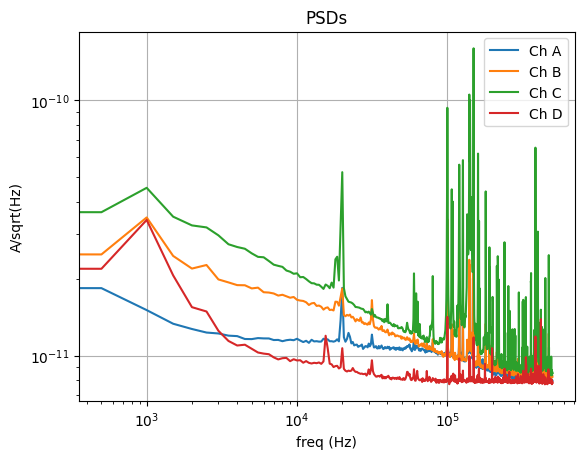

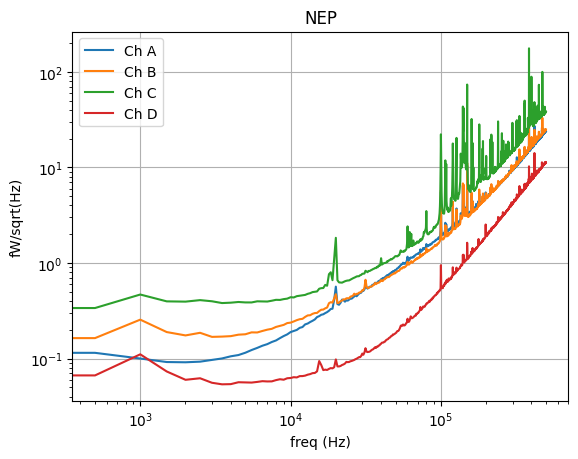

In [5]:
# calculate NEP from PSD data and write to txt files

psd_data_output_dir = folder_base + 'B13_Runs_LabVIEW/Run94/'

def read_PSD(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    psd = np.loadtxt(filename)
    fs, _ = qp.utils.fold_spectrum(qp.utils.fft(np.zeros(2*psd.size-2), fs = fs)[0], fs = fs)
    return fs, psd

fig1, ax1 = plt.subplots(1,1)
ax1.set_title('PSDs')

fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

psd_path = folder_base + '/B13_Runs_LabVIEW/Run94/Sapphire_ChABCD_SWT_weekend/Analysis 13/'


dpdi = {}

for chan in 'ABCD':
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)
    dpdi[chan], dpdi_err = qp.get_dPdI_with_uncertainties(fs, didvfit[chan][3])

    #np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

    ax1.plot(fs, psd, label = f'Ch {chan}')
    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')


ax1.grid()
ax2.grid()
ax1.loglog()
ax2.loglog()
ax1.set_xlabel('freq (Hz)')
ax2.set_xlabel('freq (Hz)')
ax1.set_ylabel('A/sqrt(Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax1.legend()
ax2.legend()



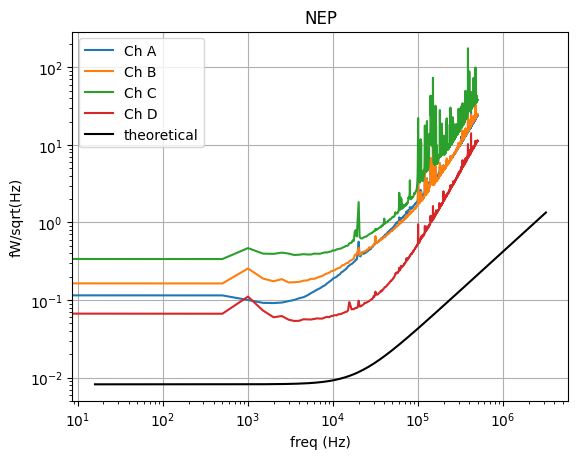

In [6]:
# compare to theoretical NEP spectrum from mpyle Ch 3

with open('Sp.txt', 'rb') as f:
    Sp, fn = pickle.load(f)


fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

for chan in 'ABCD':
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)

    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

ax2.plot(fn, 1e15*np.sqrt(Sp), label = 'theoretical', color = 'k')


ax2.grid() 
ax2.loglog()
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax2.legend()



In [7]:
dpdi['A'].shape, psd.shape

((1000,), (1000,))

In [8]:
# np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

In [9]:
# get pulse templates

templates_unnorm = {}
templates = {}

for c in 'ABCD':

    templates_unnorm[c] = np.loadtxt(psd_path + f'Templates 2/Ch {c} Template.txt')

    templates[c] = templates_unnorm[c]/templates_unnorm[c].max()

_, ts_template, ws_template = of.get_idx_tk_wn(templates['A'].size, 1e-3) # templates = 2 ms traces

fs_template = ws_template/2/np.pi # frequencies for template frequency space [Hz]

Text(0.5, 0, 'time (ms)')

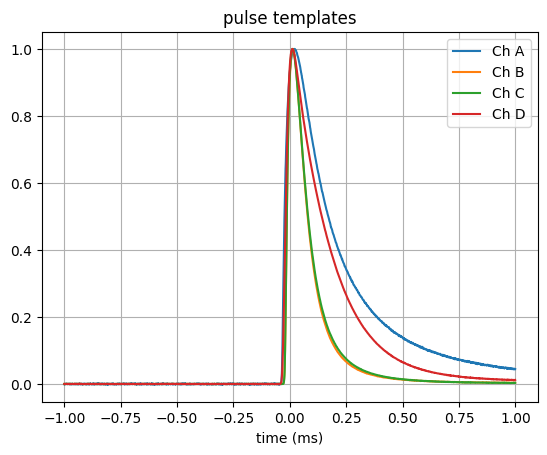

In [10]:
plt.figure()

for c in 'ABCD':
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')

#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()
plt.legend()
plt.xlabel('time (ms)')

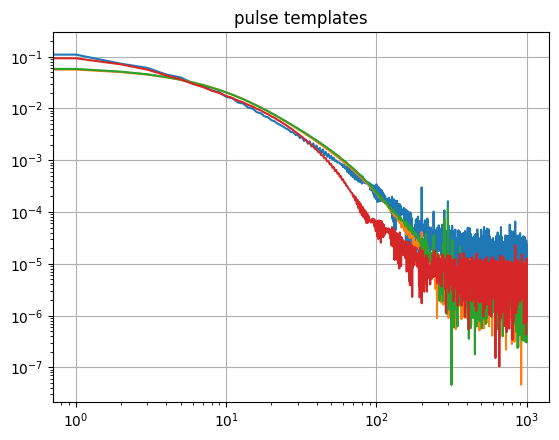

In [11]:
plt.figure()

for c in 'ABCD':
    plt.plot(abs(of.fft(templates[c])[:templates[c].size//2]), label = f'Ch {c}')

plt.loglog()
#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()

In [12]:
# convert templates to frequency domain and convert to power
pulse_power = {}

template_energy = {} # energy (keV) of template

edge_cut = 5

for c in 'ABCD':

    temp_w = of.fft(templates[c])

    #dpdi_unfolded = np.hstack((dpdi[c][::-1], dpdi[c]))/2
    dpdi_unfolded = np.hstack((abs(dpdi[c]), abs(dpdi[c])[::-1]))/2

    pow_w = temp_w*dpdi_unfolded

    pulse_power[c] = of.ifft(pow_w)

    template_energy[c] = np.trapz(np.real(pulse_power[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / 1.602e-16
    

Text(0.5, 0, 'time (ms)')

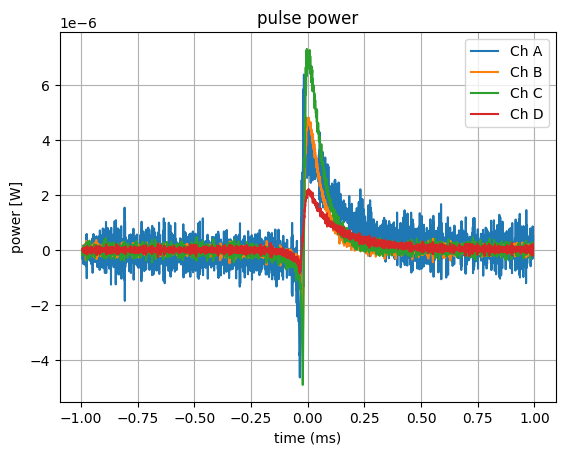

In [13]:
plt.figure()

for c in 'ABCD':
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

In [14]:
template_energy

{'A': 3642617.1695092306,
 'B': 2036878.101729824,
 'C': 3405627.6091348846,
 'D': 1978324.2175128844}

In [15]:
# calculate phonon collection efficiency

# position of 6 keV peaks
peak_positions = {
    'A': None,
    'B': 6.47901e-8,#1.78448e-7,
    'C': 5.42406e-8, #8.97955e-8,
    'D': None
}

peak_energy = 6.

print('phonon collection efficiencies')
for c in 'ABCD':
    if peak_positions[c]:
        unit_energy = 6./peak_positions[c] # energy of pulse with unit height
        print(c, ':', f'{100*template_energy[c]/unit_energy:.5g} %')

phonon collection efficiencies
B : 2.1995 %
C : 3.0787 %


Text(0.5, 0, 'time (ms)')

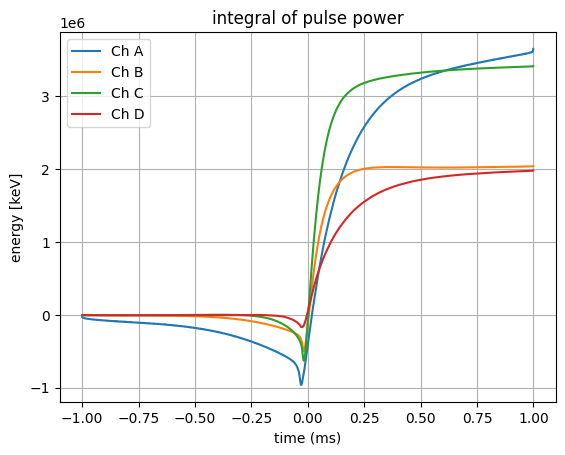

In [16]:
# cumulative energy
plt.figure()

for c in 'ABCD':
    plt.plot(1e3*ts_template[1:], si.cumulative_trapezoid(np.real(pulse_power[c])/1.6e-16, ts_template), label = f'Ch {c}')

plt.title('integral of pulse power')
plt.grid()
plt.legend()
plt.ylabel('energy [keV]')
plt.xlabel('time (ms)')